# Part II of Project 2: - Ames Housing Data and Kaggle Challenge
This notebook is a continuation from [Part I of Project 2: - Ames Housing Data and Kaggle Challenge](./part1_dataprep.ipynb).

## Data Dictionary

The data dictionary can be referenced [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

## Contents:
- [Define the functions to be used](#Define-the-functions-to-be-used)
- [Pre-processing](#Pre-processing)
    - [Train/test split](#Train/test-split)
    - [Scale the data](#Scale-the-data)
- [Model Benchmarks](#Model-Benchmarks)
- [Model Tuning](#Model-Tuning)
    - [Results after modeling](#Results-after-modeling)
    - [RFE for feature selection](#Use-RFE-for-feature-selection)
    - [Results using Optimal features from RFE](#Results-using-optimal-features-from-RFE)
- [Production Model and Insights](#Production-Model-&-Insights)
    - [Summary of the production model](#Summary-of-the-production-model:)
- [Business Recommendations](#Business-Recommendations)

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE, RFECV

import warnings
warnings.filterwarnings('ignore')

Read in the train and test data.

In [2]:
train_final = pd.read_csv('./datasets/train_final.csv')
test_final = pd.read_csv('./datasets/test_final.csv')

Next prepare the X and y from train data for train_test_split and X from test data.

In [3]:
# create X and y for train_test_split input
X_train_final = train_final.drop(columns=['saleprice','id'], axis=1)
y_train_final = train_final['saleprice']

# drop saleprice column from test data after it was created during align with train data
X_kaggle = test_final.drop(columns=['saleprice','id'], axis=1)

### Define the functions to be used
[Back to Contents](#Contents:)


Two functions have been defined.
- r2_adj calculates and returns the adjusted R2 value


- get_metrics fits the model needed and reports the metrics on the performance of the model

In [4]:
# r2_adj returns the adjusted r2 value from an r2 value
def r2_adj(r2, n, k):
    # n is # of observations, k is number of independant variables
    return 1 - ((1-r2)*(n-1)/(n-k-1))

# get metrics will apply scaling to X variables
def get_metrics(X_train_scaled, X_test_scaled, y_train, y_test, model, alphas=0):
    # Get the rows and feature count needed for calculating adj r2
    n_train = len(X_train_scaled)
    n_test = len(X_test_scaled)
    k = X_train_scaled.shape[1]
    
    if model=='lr':
        # Create Linear Regression model
        model = LinearRegression()
        
    elif model=='ridge':
        # Create RidgeCV model for alpha selection
        ridgeCV = RidgeCV(alphas=alphas, cv=5)
        
        # Get optimal alpha using RidgeCV
        ridgeCV.fit(X_train_scaled, y_train)
        
        # Create Ridge model using optimal alpha
        model = Ridge().set_params(alpha=ridgeCV.alpha_)
        
    elif model=='lasso':
        # Create LassoCV model for alpha selection
        lassoCV = LassoCV(alphas=alphas, cv=5);
        
        # Get optimal alpha using LassoCV
        lassoCV.fit(X_train_scaled, y_train)

        # Create Lasso model using optimal alpha
        model = Lasso().set_params(alpha=lassoCV.alpha_)
        
    elif model=='enet':
        # Create ElasticNetCV model for alpha selection  
        enetCV = ElasticNetCV(alphas=alphas, l1_ratio=np.arange(0.1,0.9,0.1), cv=10)
        
        # Get optimal alpha using LassoCV
        enetCV.fit(X_train_scaled, y_train)

        # Create ElasticNet model using optimal alpha and l1_ratio
        model = ElasticNet().set_params(alpha=enetCV.alpha_, l1_ratio=enetCV.l1_ratio_)

    # estimate of test R2 using cross validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    # estimate of test RMSE using cross validation
    cv_rmse = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    # fit model
    model.fit(X_train_scaled, y_train)

    print('{} Performance for {} features.\n'.format(model, k) + '-' * 52)
    print('Estimate of Testing Adj. R2: {:.4f}'.format(r2_adj(cv_scores.mean(), n_train, k)))
    print('Training Adj. R2: {:.4f}'.format(r2_adj(model.score(X_train_scaled, y_train), n_train, k)))
    print('Test Adj. R2: {:.4f}\n'.format(r2_adj(model.score(X_test_scaled, y_test), n_test, k)))

    print('Estimate of Testing RMSE: {:.0f}'.format(cv_rmse.mean()))
    print('Training RMSE: {:.0f}'.format(np.sqrt(mean_squared_error(y_train, model.predict(X_train_scaled)))))
    print('Test RMSE: {:.0f}'.format(np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))))
    
    return model

> <font size=3 color='blue'> Well done.

### Train/test split
[Back to Contents](#Contents:)

In [5]:
# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_final, y_train_final,random_state=42,test_size=0.33)

In [6]:
len(X_train.columns), len(X_test.columns), len(X_kaggle.columns)

(126, 126, 126)

### Scale the data
[Back to Content](#Contents:)

In [7]:
ss = StandardScaler()

# fit and transform using X_train, apply the same scale to X_test
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# also transform X_kaggle
X_kaggle_scaled = ss.transform(X_kaggle)

In [8]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,lot_shape,overall_qual,overall_cond,exter_qual,bsmt_qual,bsmt_exposure,heating_qc,bedroom_abvgr,kitchen_qual,totrms_abvgrd,...,foundation_Wood,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,garage_finish_1,garage_finish_2,garage_finish_3
0,0.69455,-2.293842,-1.433157,-0.659078,-3.930840,-1.532087,-0.124515,-1.032578,-0.747458,-0.212359,...,-0.039118,-1.199006,-0.114708,-0.241258,-0.073324,1.632993,-0.243026,1.147525,-0.628906,-0.545274
1,-1.08464,0.749887,-0.514898,-0.659078,0.627715,-0.557596,-1.149613,-1.032578,-0.747458,-0.212359,...,-0.039118,0.834024,-0.114708,-0.241258,-0.073324,-0.612372,-0.243026,-0.871441,-0.628906,1.833939
2,-1.08464,1.510820,-0.514898,1.168746,1.767354,0.416895,0.900583,0.237765,0.835750,1.239224,...,-0.039118,0.834024,-0.114708,-0.241258,-0.073324,-0.612372,-0.243026,-0.871441,1.590063,-0.545274
3,0.69455,-0.011045,-0.514898,-0.659078,-0.511923,-0.557596,-0.124515,-1.032578,-0.747458,-0.938151,...,-0.039118,-1.199006,-0.114708,-0.241258,-0.073324,1.632993,-0.243026,1.147525,-0.628906,-0.545274
4,0.69455,-0.011045,-0.514898,-0.659078,-0.511923,-0.557596,0.900583,-1.032578,-0.747458,0.513433,...,-0.039118,-1.199006,-0.114708,-0.241258,-0.073324,1.632993,-0.243026,1.147525,-0.628906,-0.545274


All columns have been standardized.

## Model Benchmarks
[Back to Contents](#Contents:)


Establish baseline score.

In [9]:
# use y-mean for y-test
y_baseline = [y_test.mean() for y in y_test]

In [10]:
# use get_metrics to return results for baseline
model = get_metrics(X_train_scaled, X_test_scaled, y_train, y_baseline, 'lr')

LinearRegression() Performance for 126 features.
----------------------------------------------------
Estimate of Testing Adj. R2: -281638598537284386816.0000
Training Adj. R2: 0.9150
Test Adj. R2: -0.2428

Estimate of Testing RMSE: 428163869000916
Training RMSE: 17481
Test RMSE: 846190597510615


#### Baseline Scores:
- Adj. R2: -0.2428
- RMSE: 846190597510615

## Model Tuning
[Back to Contents](#Contents:)


Fit the models and tune to the optimal setting.

In [11]:
# LR
lr_model126 = get_metrics(X_train_scaled, X_test_scaled, y_train, y_test, 'lr')

LinearRegression() Performance for 126 features.
----------------------------------------------------
Estimate of Testing Adj. R2: -281638598537284386816.0000
Training Adj. R2: 0.9150
Test Adj. R2: -194845734913496023040.0000

Estimate of Testing RMSE: 428163869000916
Training RMSE: 17481
Test RMSE: 846190597519207


#### Observations for LR model:
- Adj. R2 on test data is negative, the model is performing worse than the baseline model.


- RMSE is in the trillions! too much overfitting.


- No further tuning possible for hyperparameters

In [12]:
# Ridge alphas
alphas=np.logspace(0,3,num=200)
alphas

array([   1.        ,    1.03532184,    1.07189132,    1.1097525 ,
          1.148951  ,    1.18953407,    1.2315506 ,    1.27505124,
          1.3200884 ,    1.36671636,    1.4149913 ,    1.4649714 ,
          1.51671689,    1.57029012,    1.62575567,    1.68318035,
          1.74263339,    1.80418641,    1.8679136 ,    1.93389175,
          2.00220037,    2.07292178,    2.1461412 ,    2.22194686,
          2.30043012,    2.38168555,    2.46581108,    2.55290807,
          2.64308149,    2.73644   ,    2.8330961 ,    2.93316628,
          3.03677112,    3.14403547,    3.2550886 ,    3.37006433,
          3.48910121,    3.6123427 ,    3.7399373 ,    3.87203878,
          4.00880633,    4.15040476,    4.2970047 ,    4.44878283,
          4.60592204,    4.7686117 ,    4.93704785,    5.11143348,
          5.29197874,    5.47890118,    5.67242607,    5.87278661,
          6.08022426,    6.29498899,    6.5173396 ,    6.74754405,
          6.98587975,    7.2326339 ,    7.48810386,    7.75259

In [13]:
# Ridge fit
ridge_model126 = get_metrics(X_train_scaled, X_test_scaled, y_train, y_test, 'ridge', alphas)

Ridge(alpha=94.37878277775381) Performance for 126 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.8914
Training Adj. R2: 0.9119
Test Adj. R2: 0.8706

Estimate of Testing RMSE: 19624
Training RMSE: 17791
Test RMSE: 21804


#### Observations for Ridge model:
- Ridge model performs quite well on test data, with RMSE of 21804.


- Optimal alpha found at 94.4

In [14]:
# Lasso alphas
alphas=np.arange(440, 460, 0.1)
len(alphas)

200

In [15]:
# Lasso fit
lasso_model126 = get_metrics(X_train_scaled, X_test_scaled, y_train, y_test, 'lasso', alphas)

Lasso(alpha=448.700000000002) Performance for 126 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.8916
Training Adj. R2: 0.9078
Test Adj. R2: 0.8696

Estimate of Testing RMSE: 19570
Training RMSE: 18207
Test RMSE: 21888


#### Observations for Lasso model:
- Lasso model did not perform as well as ridge model


- Adj. R2 is lower and RMSE is also higher.


- Optimal alpha found at 448.7

In [16]:
# ElasticNet alphas
alphas = np.arange(0.09, 0.1, 0.0001)
alphas

array([0.09  , 0.0901, 0.0902, 0.0903, 0.0904, 0.0905, 0.0906, 0.0907,
       0.0908, 0.0909, 0.091 , 0.0911, 0.0912, 0.0913, 0.0914, 0.0915,
       0.0916, 0.0917, 0.0918, 0.0919, 0.092 , 0.0921, 0.0922, 0.0923,
       0.0924, 0.0925, 0.0926, 0.0927, 0.0928, 0.0929, 0.093 , 0.0931,
       0.0932, 0.0933, 0.0934, 0.0935, 0.0936, 0.0937, 0.0938, 0.0939,
       0.094 , 0.0941, 0.0942, 0.0943, 0.0944, 0.0945, 0.0946, 0.0947,
       0.0948, 0.0949, 0.095 , 0.0951, 0.0952, 0.0953, 0.0954, 0.0955,
       0.0956, 0.0957, 0.0958, 0.0959, 0.096 , 0.0961, 0.0962, 0.0963,
       0.0964, 0.0965, 0.0966, 0.0967, 0.0968, 0.0969, 0.097 , 0.0971,
       0.0972, 0.0973, 0.0974, 0.0975, 0.0976, 0.0977, 0.0978, 0.0979,
       0.098 , 0.0981, 0.0982, 0.0983, 0.0984, 0.0985, 0.0986, 0.0987,
       0.0988, 0.0989, 0.099 , 0.0991, 0.0992, 0.0993, 0.0994, 0.0995,
       0.0996, 0.0997, 0.0998, 0.0999, 0.1   ])

In [17]:
# ElasticNet fit
enet_model126 = get_metrics(X_train_scaled, X_test_scaled, y_train, y_test, 'enet', alphas)

ElasticNet(alpha=0.09540000000000015, l1_ratio=0.30000000000000004) Performance for 126 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.8913
Training Adj. R2: 0.9121
Test Adj. R2: 0.8708

Estimate of Testing RMSE: 19634
Training RMSE: 17772
Test RMSE: 21790


#### Observations for ElasticNet model:
- ElasticNet model performed the best amongst all 4 models


- Highest Adj. R2 of 0.8708 and lowest RMSE of 21790.


- Optimal alpha found at 0.095, optimal l1_ratio is 0.3 (i.e. 0.3 for l1 and 0.7 for l2 penalization)

### Results after modeling
[Back to Content](#Contents:)


On unseen data, **ElasticNet model** returned the best performance:
- **Adj. R2 score: 0.8708**
- **RMSE: 21790**

Submit 1st round results to Kaggle to see how it performs on unseen data.

In [18]:
# using ridge model, get y-hat using X_test_submit data
test_final['saleprice'] = ridge_model126.predict(X_kaggle_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_ridge_126.csv',index=False)

**Kaggle score for Ridge model:**
- Public: 31,550
- Private: 25,500

In [19]:
# using lasso model, get y-hat using test data
test_final['saleprice'] = lasso_model126.predict(X_kaggle_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_lasso_126.csv',index=False)

**Kaggle score for Lasso model:**
- Public: 32,017
- Private: 25,044

In [20]:
# using enet model, get y-hat using test data
test_final['saleprice'] = enet_model126.predict(X_kaggle_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_enet_126.csv',index=False)

**Kaggle score for ElasticNet model:**
- Public: 31,538
- Private: 25,408

**The Lasso model performed better on Kaggle test data though.**

## Use RFE for feature selection
[Back to Contents](#Contents:)


Use Recursive Feature Elimination or RFE to determine optimal number of features with the ElasticNet model.

In [21]:
# Use enet model with RFECV
selector = RFECV(enet_model126, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)
selector.n_features_

55

55 is the optimal number of features.

Which are the 55 features?

In [22]:
# Initializing RFE model
rfe = RFE(enet_model126, n_features_to_select=55)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled, y_train) 

# Fitting the data to model
enet_model126.fit(X_rfe, y_train)

features = pd.Series(rfe.support_, index=X_train.columns)
optimal_features = features[features==True].index.values
optimal_features

array(['overall_qual', 'overall_cond', 'exter_qual', 'bsmt_qual',
       'bsmt_exposure', 'heating_qc', 'bedroom_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'fireplaces', 'fireplace_qu', 'garage_qual',
       'bsmt_bath', 'bath', 'total_bsmt_sf^2',
       'total_bsmt_sf gr_liv_area', 'total_bsmt_sf garage_area',
       'total_bsmt_sf age_built', 'gr_liv_area^2',
       'gr_liv_area garage_area', 'gr_liv_area age_built',
       'garage_area^2', 'garage_area age_built', 'ms_subclass_30',
       'ms_subclass_90', 'ms_subclass_120', 'ms_subclass_160',
       'ms_subclass_180', 'ms_subclass_190', 'ms_zoning_C (all)',
       'ms_zoning_RM', 'neighborhood_BrDale', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_GrnHill',
       'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_SawyerW', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'neighborhood_Timber',
       'neighborhood_Veenker', '

Let's plot the features and their coefficients.

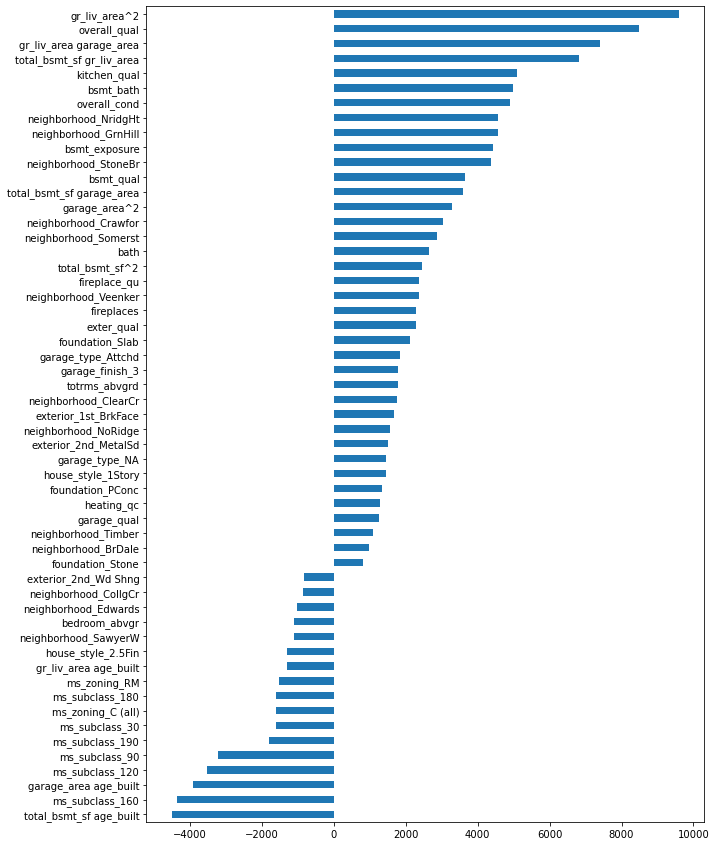

In [23]:
coef = pd.Series(enet_model126.coef_, optimal_features)
plt.figure(figsize=(10,15))
coef.sort_values().plot.barh();

#### Observations on optimal features:
- `gr_liv_area`, `overall_qual` and `garage_area` come up as top features affecting the price of a house.


- Certain `neighbourhoods` increase the predicted price while certain `subclass` types have negative impact on the predict price.


- The list is definitely too long to be useful to someone who wants to quickly predict the price of a house. Just getting all the information needed for this list seems like a daunting task.

### Results using optimal features from RFE
[Back to Contents](#Contents:)


Let's look at how the optimal model performs before we continue to reduce the number of features to a more user-friendly number. 

In [24]:
# Create X_train, X_test and X_kaggle with optimal features recommended by RFE
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]
X_kaggle_optimal = X_kaggle[optimal_features]

ss = StandardScaler()

# fit and transform using X_train, apply the same scale to X_test
X_train_optimal_scaled = ss.fit_transform(X_train_optimal)
X_test_optimal_scaled = ss.transform(X_test_optimal)

# also transform X_kaggle
X_kaggle_optimal_scaled = ss.transform(X_kaggle_optimal)

In [25]:
# LR
lr_model55 = get_metrics(X_train_optimal_scaled, X_test_optimal_scaled, y_train, y_test, 'lr')

LinearRegression() Performance for 55 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.9014
Training Adj. R2: 0.9159
Test Adj. R2: 0.8862

Estimate of Testing RMSE: 19233
Training RMSE: 17900
Test RMSE: 21804


- Adj. R2 on test data is now 0.8862. The model is performing better than enet was with 126 features.


- RMSE has reduced from trillions to just 21804, very close to enet's RMSE of 21790 with 126 features.


- LR Model has improved significantly, improving over enet's model with 126 features. 

In [26]:
# Ridge alphas
alphas=np.logspace(0,2,num=200)

In [27]:
# Ridge fit
ridge_model55 = get_metrics(X_train_optimal_scaled, X_test_optimal_scaled, y_train, y_test, 'ridge', alphas)

Ridge(alpha=72.32633896483537) Performance for 55 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.9039
Training Adj. R2: 0.9152
Test Adj. R2: 0.8850

Estimate of Testing RMSE: 18991
Training RMSE: 17977
Test RMSE: 21917


#### Ridge observations:
- Adj R2 improved from 0.8706 previously but RMSE increased from 21804.


- Both bias and variance has dropped.

In [28]:
# Lasso alphas
alphas=np.arange(60, 80, 0.1)

In [29]:
# Lasso fit
lasso_model55 = get_metrics(X_train_optimal_scaled, X_test_optimal_scaled, y_train, y_test, 'lasso', alphas)

Lasso(alpha=62.10000000000003) Performance for 55 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.9016
Training Adj. R2: 0.9158
Test Adj. R2: 0.8866

Estimate of Testing RMSE: 19207
Training RMSE: 17912
Test RMSE: 21768


#### Lasso observations:
- Adj R2 increased from 0.8696 and RMSE dropped from 21888.


- Overfitting has been reduced.

In [30]:
# ElasticNet alphas
alphas = np.arange(0.01, 0.1, 0.001)

In [31]:
# ElasticNet fit
enet_model55 = get_metrics(X_train_optimal_scaled, X_test_optimal_scaled, y_train, y_test, 'enet', alphas)

ElasticNet(alpha=0.05899999999999996, l1_ratio=0.1) Performance for 55 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.9038
Training Adj. R2: 0.9152
Test Adj. R2: 0.8851

Estimate of Testing RMSE: 18998
Training RMSE: 17972
Test RMSE: 21911


#### ElasticNet observations:
- Adj. R2 has improved from 0.8708 but RMSE has increased from 21790.


- Bias has increased while variance dropped.

#### Summary for optimal model performance
On unseen data, **Lasso model** with optimal features returned the best performance:
- **Adj. R2 score: 0.8866**
- **RMSE: 21768**

Submit 2nd round results to Kaggle to see how it performs on unseen data.

In [32]:
# using lr model, get y-hat using X_test_submit data
test_final['saleprice'] = lr_model55.predict(X_kaggle_optimal_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_lr_55.csv',index=False)

**Kaggle score for LR model:**
- Public: 31,572
- Private: 24,321

In [33]:
# using ridge model, get y-hat using X_test_submit data
test_final['saleprice'] = ridge_model55.predict(X_kaggle_optimal_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_ridge_55.csv',index=False)

**Kaggle score for Ridge model:**
- Public: 31,492
- Private: 25,203

In [34]:
# using lasso model, get y-hat using test data
test_final['saleprice'] = lasso_model55.predict(X_kaggle_optimal_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_lasso_55.csv',index=False)

**Kaggle score for Lasso model:**
- Public: 31,586
- Private: 24,357

In [35]:
# using enet model, get y-hat using test data
test_final['saleprice'] = enet_model55.predict(X_kaggle_optimal_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_enet_55.csv',index=False)

**Kaggle score for ElasticNet model:**
- Public: 31,490
- Private: 25,170

**Observation:**
- The LR model had the lowest private score on Kaggle test data.

### Production Model & Insights
[Back to Contents](#Contents:)


Let's now use RFE to select the best 25 features for our prediction model.

In [36]:
# Initializing RFE model with enet_model with 126 features
rfe = RFE(enet_model126, n_features_to_select=25)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled, y_train) 

# Fitting the data to model
enet_model126.fit(X_rfe, y_train)

features = pd.Series(rfe.support_, index=X_train.columns)
top_features = features[features==True].index.values
top_features

array(['overall_qual', 'overall_cond', 'exter_qual', 'bsmt_exposure',
       'kitchen_qual', 'fireplaces', 'fireplace_qu', 'bsmt_bath', 'bath',
       'total_bsmt_sf^2', 'total_bsmt_sf gr_liv_area',
       'total_bsmt_sf garage_area', 'total_bsmt_sf age_built',
       'gr_liv_area^2', 'gr_liv_area garage_area',
       'gr_liv_area age_built', 'garage_area^2', 'garage_area age_built',
       'ms_subclass_90', 'ms_subclass_160', 'neighborhood_Crawfor',
       'neighborhood_GrnHill', 'neighborhood_NridgHt',
       'neighborhood_Somerst', 'neighborhood_StoneBr'], dtype=object)

In [37]:
# Create X_train, X_test and X_kaggle with only these top 25 features 
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
X_kaggle_top = X_kaggle[top_features]

# fit and transform using X_train, apply the same scale to X_test
X_train_top_scaled = ss.fit_transform(X_train_top)
X_test_top_scaled = ss.transform(X_test_top)

# also transform X_kaggle
X_kaggle_top_scaled = ss.transform(X_kaggle_top)

In [38]:
# ElasticNet alphas
alphas = np.arange(0.01, 0.1, 0.001)

In [39]:
# ElasticNet fit
enet_model25 = get_metrics(X_train_top_scaled, X_test_top_scaled, y_train, y_test, 'enet', alphas)

ElasticNet(alpha=0.05899999999999996, l1_ratio=0.2) Performance for 25 features.
----------------------------------------------------
Estimate of Testing Adj. R2: 0.8960
Training Adj. R2: 0.9035
Test Adj. R2: 0.8795

Estimate of Testing RMSE: 19940
Training RMSE: 19407
Test RMSE: 22999


**Adj R2 had dropped and RMSE had increased with final model**
- Final model is probably underfitted.

In [40]:
# using lasso model, get y-hat using test data
test_final['saleprice'] = enet_model25.predict(X_kaggle_top_scaled)
test_final[['id','saleprice']].to_csv('./output/ame_top_25.csv',index=False)

**Kaggle score for top 25 features:**
- Public: 32,905
- Private: 24,714

Similar to the earlier results with test data, the top 25 model has higher RMSE. However, the trade-off on slight drop in model accuracy to make the model easier to use is definitely worth making.

Let's plot the coefficients for the final 25 features. 

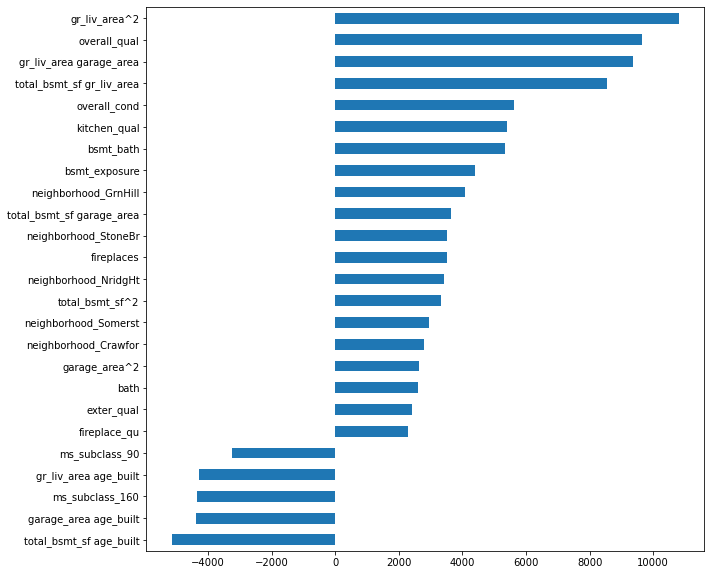

In [41]:
# list down final features and plot their coefficients
coef = pd.Series(enet_model25.coef_, top_features)
plt.figure(figsize=(10,10))
coef.sort_values().plot.barh();

### Summary of the production model:
[Back to Contents](#Contents:)


Now we are able to make a prediction on the price of a property by answering these **10 most important questions**:

    1. What is the above grade living area in sqft?
    2. How is the overall quality of material and finish of the house?
    3. What is the garage area in sqft?
    4. What is the total basement area in sqft?
    5. How is the overall condition of the house?
    6. How is the quality of kitchen?
    7. Is there a bath in the basement?
    8. Level of basement exposure
    9. Is there a fireplace?
    10. How many baths are there?


- Certain neighbourhoods like Green Hills, Stone Brook, Northridge Heights, Somerset and Crawford add a premium to the price.


- Certain dwelling types like duplex and 2-storey Planned Unit Development (1946 & newer) reduces the price.


- Age of the property has the highest negative impact on the price.

## Business Recommendations
[Back to Contents](#Contents:)

#### Some recommendations for the business:
- `Gr Liv Area` (Above ground living area square feet) and `overall_qual` (overall material and finish of the house) adds the most value to a home.


- Combined effect of `Total Bsmt SF` (Total square feet of basement area) and `age_built` (Age of the property, calculated from year built) hurt the value of a home the most.


- To increase the value of their home, besides improving the `overall quality` and `condition` of the house, homehowners could add a `bathroom in the basement` and a `fireplace` to their home. 


- The neighbourhoods of `Green Hills`, `Stone Brook`, `Northridge Heights` might be good investments.


#### Can this model be adapted to other cities?
This model will not generalize well to other cities since it includes specific neighbourhoods by name. To make it more universal, neighbourhoods could be classified into different types, e.g. urban, suburban. This [link](https://www.hgtv.com/lifestyle/real-estate/12-kinds-of-neighborhoods) shows a possible breakdown for the types of neighbourhoods to be considered.